# Drone frequency response demo

Import modules.

In [1]:
import os
import time
import secrets
import numpy as np
from scipy import linalg
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import ae353_drone

import ae353_dronecontrol # <--- has a working controller for the purpose of demonstration

# Enable interactive plots
%matplotlib widget

pybullet build time: Dec 10 2021 09:55:58


Create and print a seed for the random number generator so it is possible to reproduce the results.

In [2]:
seed = secrets.randbits(32)
print(seed)

2682348231


Create simulator with seed.

In [3]:
simulator = ae353_drone.Simulator(
    display=True,
    seed=seed,
)

By default, your controller will fail if either of the following conditions is met:

* It prints something to `stdout`.
* It exceeds the maximum runtime of `1` second for `init`, `1` second for `reset`, and `5e-3` seconds for `run`.

You can relax these rules for the purpose of development if you want, as follows.

In [4]:
simulator.set_rules(
    error_on_print=False,    # <-- allow print statements in controller code
    error_on_timeout=False,  # <-- allow long runtimes in controller code
)

Create a class derived from the controller defined in `ae353_dronecontrol.py` that redefines the function `get_xdes_and_udes`, allowing us to play around with different ways of computing these quantities for the purpose of demonstration.

**NOTE. I didn't publish the version of `ae353_dronecontrol.py` that was used in class, rather just the template version. If you want this notebook to work, you'll need to modify `ae353_dronecontrol.py` so that it works!**

In [ ]:
class DemoController(ae353_dronecontrol.Controller):
    def get_xdes_and_udes(self, t, xhat, p_x_ring, p_y_ring, p_z_ring):
        xdes = np.zeros(12)
        udes = np.zeros(4)
        
#         xdes[0:3] = np.array([0., 0., 0.5])
#         xdes[0:3] = np.array([p_x_ring, p_y_ring, p_z_ring])
        
        phat = xhat[0:3]
        pring = np.array([p_x_ring, p_y_ring, p_z_ring])
        r = 1.
        if np.linalg.norm(pring - phat) > r:
            pdes = phat + r * ((pring - phat) / np.linalg.norm(pring - phat))
        else:
            pdes = pring
        xdes[0:3] = pdes
        
        return xdes, udes

In [14]:
class DemoController(ae353_dronecontrol.Controller):
    def get_xdes_and_udes(self, t, xhat, p_x_ring, p_y_ring, p_z_ring):
        xdes = np.zeros(12)
        udes = np.zeros(4)
        
        p_x_des = 0.0
        p_z_des = 0.5
        
        omega = 1.
        p_y_des = 0.5 * np.sin(omega * t)
        
        pdes = np.array([p_x_des, p_y_des, p_z_des])
                
        phat = xhat[0:3]
        max_perr = 1.
        if np.linalg.norm(pdes - phat) > max_perr:
            pdes = phat + max_perr * ((pdes - phat) / np.linalg.norm(pdes - phat))
        xdes[0:3] = pdes
        
        return xdes, udes

Clear all drones.

In [15]:
simulator.clear_drones()

Rearrange the rings.

In [16]:
simulator.move_rings()

Add drone to simulator.

In [17]:
simulator.add_drone(DemoController, 'my_netid', 'my_image.png')

Change the camera view.

In [18]:
simulator.camera_droneview('my_netid')

Reset the drone (i.e., place it at a random location in the start ring).

In [19]:
simulator.reset()

Run simulation until `max_time` is reached or until the drone reaches the finish ring.

In [20]:
simulator.run(max_time=25.)

Get data.

In [21]:
data = simulator.get_data('my_netid')

Plot results ($y$ position only).

**NOTE.** You may be confused by these plots at first, because $p_\text{des}$ may not appear sinusoidal. Remember that your own controller is changing $p_\text{des}$ so that it is never more than a given distance away from $\widehat{p}$.

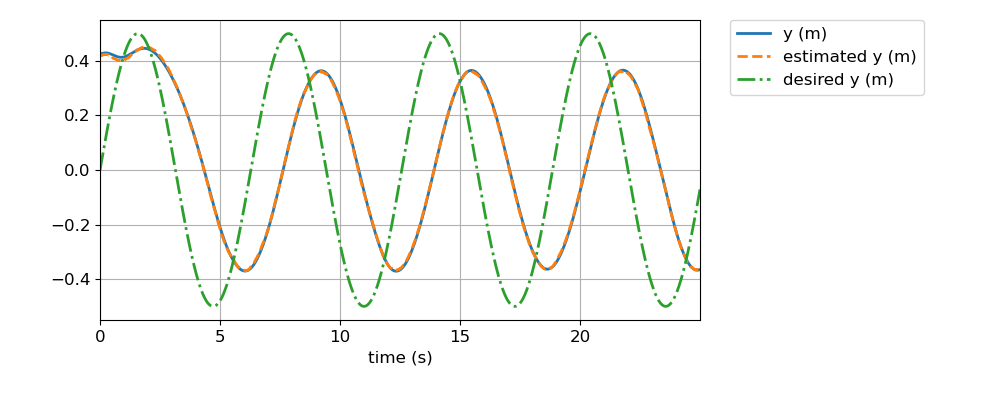

In [22]:
# Get estimated and desired y position
p_y_est = data['xhat'][:, 1]
p_y_des = data['xdes'][:, 1]

# Create figure
fig = plt.figure(figsize=(10, 4))
ax_py = fig.add_axes([0.1, 0.2, 0.6, 0.75])
ax_py.plot(data['t'], data['p_y'], label='y (m)', linewidth=2)
ax_py.plot(data['t'], p_y_est, '--', label='estimated y (m)', linewidth=2)
ax_py.plot(data['t'], p_y_des, '-.', label='desired y (m)', linewidth=2)
ax_py.grid()
ax_py.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
ax_py.tick_params(labelsize=12)
ax_py.set_xlabel('time (s)', fontsize=12)
ax_py.set_xlim([data['t'][0], data['t'][-1]])

# Show figure
plt.show()

Plot results (position only).

**NOTE.** You may be confused by these plots at first, because $p_\text{des}$ may not appear sinusoidal. Remember that your own controller is changing $p_\text{des}$ so that it is never more than a given distance away from $\widehat{p}$.

In [ ]:
p_x_est = data['xhat'][:, 0]
p_y_est = data['xhat'][:, 1]
p_z_est = data['xhat'][:, 2]

p_x_des = data['xdes'][:, 0]
p_y_des = data['xdes'][:, 1]
p_z_des = data['xdes'][:, 2]

p_x_ring = data['ring'][:, 0]
p_y_ring = data['ring'][:, 1]
p_z_ring = data['ring'][:, 2]

# Create a figure with subplots that all share the same x-axis
fig, (ax_px, ax_py, ax_pz) = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

ax_px.plot(data['t'], data['p_x'], label='x (m)', linewidth=3)
ax_px.plot(data['t'], p_x_est, '--', label='estimated x (m)', linewidth=4)
ax_px.plot(data['t'], p_x_des, ':', label='desired x (m)', linewidth=4)
ax_px.plot(data['t'], p_x_ring, '-.', label='ring x (m)', linewidth=3)
ax_px.grid()
ax_px.legend(fontsize=12)
ax_px.tick_params(labelsize=12)

ax_py.plot(data['t'], data['p_y'], label='y (m)', linewidth=3)
ax_py.plot(data['t'], p_y_est, '--', label='estimated y (m)', linewidth=4)
ax_py.plot(data['t'], p_y_des, ':', label='desired y (m)', linewidth=4)
ax_py.plot(data['t'], p_y_ring, '-.', label='ring y (m)', linewidth=3)
ax_py.grid()
ax_py.legend(fontsize=12)
ax_py.tick_params(labelsize=12)

ax_pz.plot(data['t'], data['p_z'], label='z (m)', linewidth=3)
ax_pz.plot(data['t'], p_z_est, '--', label='estimated z (m)', linewidth=4)
ax_pz.plot(data['t'], p_z_des, ':', label='desired z (m)', linewidth=4)
ax_pz.plot(data['t'], p_z_ring, '-.', label='ring z (m)', linewidth=3)
ax_pz.grid()
ax_pz.legend(fontsize=12)
ax_pz.tick_params(labelsize=12)

# Set shared x-axis properties
ax_pz.set_xlabel('time (s)', fontsize=14)
ax_pz.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()
plt.show()

Plot results (position, orientation, and actuator commands).

In [ ]:
# Create a figure with subplots that all share the same x-axis
fig, (ax_pos, ax_ori, ax_act) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Position
ax_pos.plot(data['t'], data['p_x'], label='x (m)', linewidth=3, color='C0')
ax_pos.plot(data['t'], data['p_y'], label='y (m)', linewidth=3, color='C1')
ax_pos.plot(data['t'], data['p_z'], label='z (m)', linewidth=3, color='C2')
ax_pos.plot(data['t'], data['p_x_meas'], '.', label='measured x (m)', markersize=3, color='C0')
ax_pos.plot(data['t'], data['p_y_meas'], '.', label='measured y (m)', markersize=3, color='C1')
ax_pos.plot(data['t'], data['p_z_meas'], '.', label='measured z (m)', markersize=3, color='C2')
ax_pos.grid()
ax_pos.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_pos.tick_params(labelsize=14)

# Orientation
ax_ori.plot(data['t'], data['yaw'], label='yaw (rad)', linewidth=3)
ax_ori.plot(data['t'], data['pitch'], label='pitch (rad)', linewidth=3)
ax_ori.plot(data['t'], data['roll'], label='roll (rad)', linewidth=3)
ax_ori.plot(data['t'], data['yaw_meas'], '.', label='measured yaw (rad)', markersize=3, color='C0')
ax_ori.grid()
ax_ori.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_ori.tick_params(labelsize=14)

# Actuator commands
ax_act.plot(data['t'], data['tau_x'], label='tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_x_cmd'], '--', label='commanded tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y'], label='tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y_cmd'], '--', label='commanded tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z'], label='tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z_cmd'], '--', label='commanded tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['f_z'] - (0.5 * 9.81), label='f_z - m g (N)', linewidth=4) # <-- FIXME
ax_act.plot(data['t'], data['f_z_cmd'] - (0.5 * 9.81), '--', label='commanded f_z - m g (N)', linewidth=4) # <-- FIXME
ax_act.grid()
ax_act.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_act.tick_params(labelsize=14)
# ax_act.set_ylim(-10, 10) # <-- FIXME

# Set shared x-axis properties
ax_act.set_xlabel('time (s)', fontsize=20)
ax_act.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()
plt.show()

Plot histogram of controller run times.

In [ ]:
plt.hist(data['run_time'])
plt.ticklabel_format(style='scientific', scilimits=(0, 0), axis='x')
plt.tick_params(labelsize=14)
plt.xlabel('run time (s)', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.tight_layout()
plt.show()

## Analysis of frequency response

Get model.

In [23]:
# This is something you can do yourself as well
drone = simulator.get_drone_by_name('my_netid')
controller = drone['controller']

# This is something you cannot do yourself, unless you add
# the function get_model() to your Controller class.
A, B, C, K, L = controller.get_model()

Define a matrix that picks the *only* element of $x_\text{des}$ that varies.

In [24]:
M = np.zeros((12, 1))
M[1, 0] = 1.

Define closed-loop model.

In [25]:
Am = np.block([[A - B @ K, -B @ K], [np.zeros_like(A), A - L @ C]])
Bm = np.block([[- (A - B @ K) @ M], [np.zeros_like(M)]])
Cm = np.block([[M.T, np.zeros((1, A.shape[0]))]])

Define the function

$$H(s) = C_m (s - A_m)^{-1} B_m$$

where $s\in\mathbb{C}$ is a complex number.

In [26]:
H = lambda s: (Cm @ linalg.inv(s * np.eye(Am.shape[0]) - Am) @ Bm).item()

Find the magnitude $|H(j\omega)|$ and the angle $\angle H(j\omega)$ of the complex number $H(j\omega)$ for different choices of frequency $\omega$ (radians / second).

Remember that any complex number $z\in\mathbb{C}$ can be written as

$$z = |z|e^{\angle z} = |z| \left( \cos(\angle z) + j \sin(\angle z) \right)$$

and that the period $T$ (in seconds) of a sinusoid with frequency $\omega$ (in radians / second) is

$$T = \dfrac{2\pi}{\omega}.$$

In [27]:
omega = 1.
H_of_jomega = H(1j * omega)
magH = np.absolute(H_of_jomega)
angH = np.angle(H_of_jomega)

print(f'omega = {omega}')
print(f'H(j omega) = {H_of_jomega:.4f}')
print(f'mag = {magH:.4f}')
print(f'ang = {angH:.4f}')

omega = 1.0
H(j omega) = 0.2161-0.6694j
mag = 0.7035
ang = -1.2585


Create Bode plot (i.e., plot magnitude and angle of $H(jw)$ as $w$ varies).

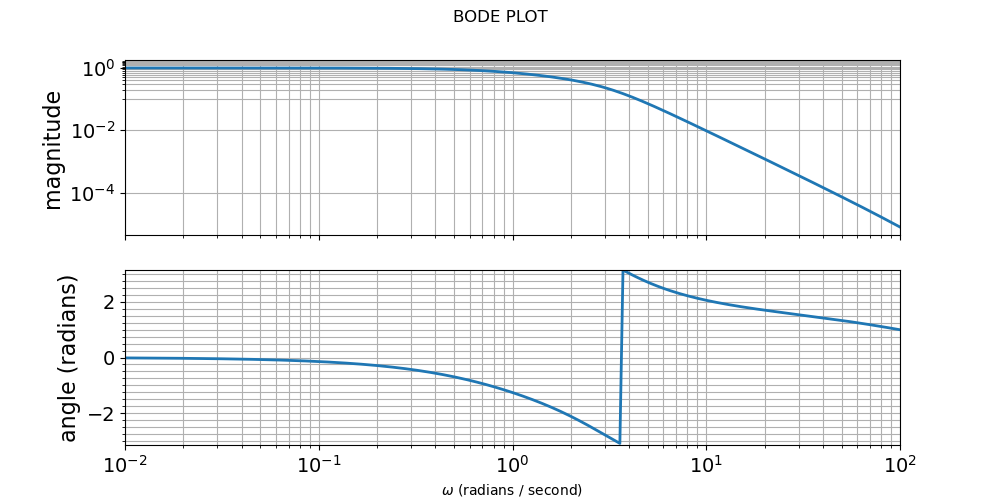

In [30]:
omega = np.logspace(-2, 2, 250)
H_at_jomega = np.empty_like(omega, dtype=complex)
for i in range(len(omega)):
    H_at_jomega[i] = H(1j * omega[i])
mag = np.absolute(H_at_jomega)
ang = np.angle(H_at_jomega)

fig, (ax_mag, ax_ang) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax_mag.loglog(omega, mag, linewidth=2)
ax_mag.grid(visible=True, which='both', axis='both')
ax_mag.tick_params(labelsize=14)
ax_mag.yaxis.set_minor_locator(MultipleLocator(1e-1))
ax_mag.set_yticklabels([], minor=True)
ax_mag.set_ylabel('magnitude', fontsize=16)
ax_ang.semilogx(omega, ang, linewidth=2)
ax_ang.grid(visible=True, which='both', axis='both')
ax_ang.tick_params(labelsize=14)
ax_ang.yaxis.set_minor_locator(MultipleLocator(0.25))
ax_ang.set_yticklabels([], minor=True)
ax_ang.set_ylabel('angle (radians)', fontsize=16)
ax_ang.set_ylim([-np.pi, np.pi])
ax_ang.set_xlim([min(omega), max(omega)])
ax_ang.set_xlabel(r'$\omega$ (radians / second)')
fig.suptitle('BODE PLOT')
plt.show()

Show Bode plot again but this time with magnitude in dB and with angle in degrees.

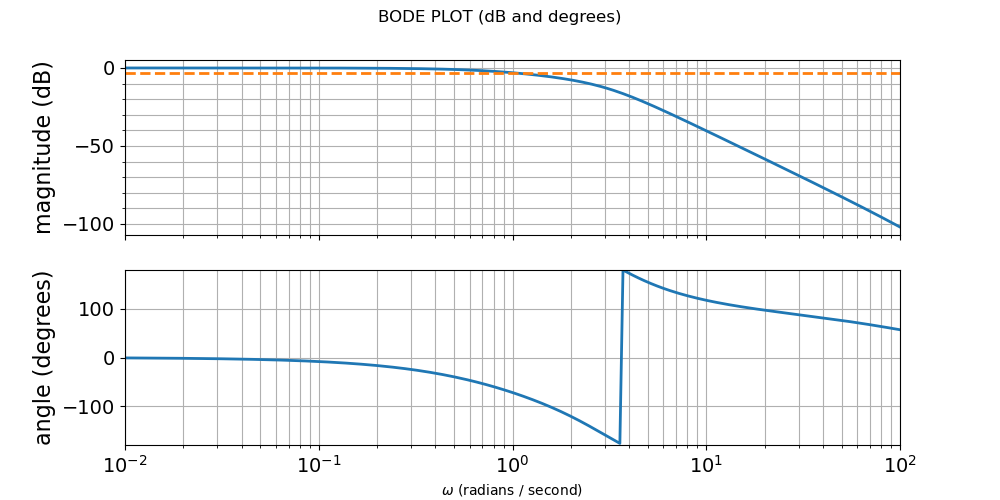

In [31]:
omega = np.logspace(-2, 2, 250)
H_at_jomega = np.empty_like(omega, dtype=complex)
for i in range(len(omega)):
    H_at_jomega[i] = H(1j * omega[i])
mag = 20 * np.log10(np.absolute(H_at_jomega))
ang = np.rad2deg(np.angle(H_at_jomega))

fig, (ax_mag, ax_ang) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax_mag.semilogx(omega, mag, linewidth=2)
ax_mag.semilogx(omega, -3. * np.ones_like(omega), '--', linewidth=2)
ax_mag.grid(visible=True, which='both', axis='both')
ax_mag.tick_params(labelsize=14)
ax_mag.yaxis.set_minor_locator(MultipleLocator(10))
ax_mag.set_yticklabels([], minor=True)
ax_mag.set_ylabel('magnitude (dB)', fontsize=16)
ax_ang.semilogx(omega, ang, linewidth=2)
ax_ang.grid(visible=True, which='both', axis='both')
ax_ang.tick_params(labelsize=14)
# ax_ang.yaxis.set_minor_locator(MultipleLocator(0.25))
ax_ang.set_yticklabels([], minor=True)
ax_ang.set_ylabel('angle (degrees)', fontsize=16)
ax_ang.set_ylim([-180, 180])
ax_ang.set_xlim([min(omega), max(omega)])
ax_ang.set_xlabel(r'$\omega$ (radians / second)')
fig.suptitle('BODE PLOT (dB and degrees)')
plt.show()

Compare predicted to actual response.

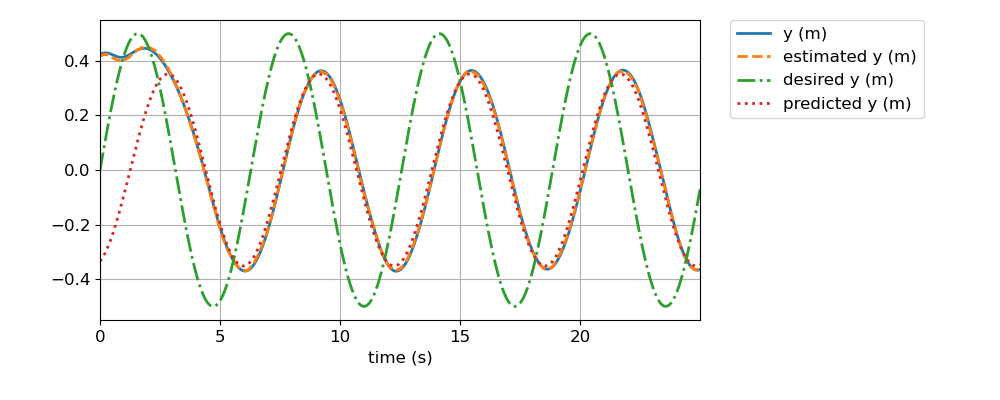

In [29]:
# Get estimated and desired y position
p_y_est = data['xhat'][:, 1]
p_y_des = data['xdes'][:, 1]
t = data['t']
omega = 1.
p_y_pre = 0.5 * np.absolute(H(1j * omega)) * np.sin(omega * t + np.angle(H(1j * omega)))

# Create figure
fig = plt.figure(figsize=(10, 4))
ax_py = fig.add_axes([0.1, 0.2, 0.6, 0.75])
ax_py.plot(data['t'], data['p_y'], label='y (m)', linewidth=2)
ax_py.plot(data['t'], p_y_est, '--', label='estimated y (m)', linewidth=2)
ax_py.plot(data['t'], p_y_des, '-.', label='desired y (m)', linewidth=2)
ax_py.plot(data['t'], p_y_pre, ':', label='predicted y (m)', linewidth=2)
ax_py.grid()
ax_py.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
ax_py.tick_params(labelsize=12)
ax_py.set_xlabel('time (s)', fontsize=12)
ax_py.set_xlim([data['t'][0], data['t'][-1]])

# Show figure
plt.show()

## Example of how to get and plot results

Assume that we already did two things:

* Added a drone with the name `my_netid` to the simulator
* Ran the simulation

Get result.

In [ ]:
(
    did_it_fail,
    did_it_finish,
    what_time_did_it_finish,
) = simulator.get_result('my_netid')

Show result.

In [ ]:
if did_it_fail:
    print('The drone failed before finishing.')
elif did_it_finish:
    print(f'The drone finished at time {what_time_did_it_finish}')
else:
    print('The drone did not finish (yet).')

Get data.

In [ ]:
data = simulator.get_data('my_netid')

Plot results.

In [ ]:
# Create a figure with subplots that all share the same x-axis
fig, (ax_pos, ax_ori, ax_act) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Position
ax_pos.plot(data['t'], data['p_x'], label='x (m)', linewidth=3, color='C0')
ax_pos.plot(data['t'], data['p_y'], label='y (m)', linewidth=3, color='C1')
ax_pos.plot(data['t'], data['p_z'], label='z (m)', linewidth=3, color='C2')
ax_pos.plot(data['t'], data['p_x_meas'], '.', label='measured x (m)', markersize=3, color='C0')
ax_pos.plot(data['t'], data['p_y_meas'], '.', label='measured y (m)', markersize=3, color='C1')
ax_pos.plot(data['t'], data['p_z_meas'], '.', label='measured z (m)', markersize=3, color='C2')
ax_pos.grid()
ax_pos.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_pos.tick_params(labelsize=14)

# Orientation
ax_ori.plot(data['t'], data['yaw'], label='yaw (rad)', linewidth=3)
ax_ori.plot(data['t'], data['pitch'], label='pitch (rad)', linewidth=3)
ax_ori.plot(data['t'], data['roll'], label='roll (rad)', linewidth=3)
ax_ori.plot(data['t'], data['yaw_meas'], '.', label='measured yaw (rad)', markersize=3, color='C0')
ax_ori.grid()
ax_ori.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_ori.tick_params(labelsize=14)

# Actuator commands
ax_act.plot(data['t'], data['tau_x'], label='tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_x_cmd'], '--', label='commanded tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y'], label='tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y_cmd'], '--', label='commanded tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z'], label='tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z_cmd'], '--', label='commanded tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['f_z'] - (0.5 * 9.81), label='f_z - m g (N)', linewidth=4) # <-- FIXME
ax_act.plot(data['t'], data['f_z_cmd'] - (0.5 * 9.81), '--', label='commanded f_z - m g (N)', linewidth=4) # <-- FIXME
ax_act.grid()
ax_act.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_act.tick_params(labelsize=14)
# ax_act.set_ylim(-10, 10) # <-- FIXME

# Set shared x-axis properties
ax_act.set_xlabel('time (s)', fontsize=20)
ax_act.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()
plt.show()

Save the figure (without transparent background).

In [ ]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)

Plot histogram of controller run times.

In [ ]:
plt.hist(data['run_time'])
plt.ticklabel_format(style='scientific', scilimits=(0, 0), axis='x')
plt.tick_params(labelsize=14)
plt.xlabel('run time (s)', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.tight_layout()
plt.show()

Note that it is required to also plot state estimates (in comparison to states) in order to check that your observer is working - no example is provided here, since no state estimates are being generated by the template `Controller` class.

## Example of how to load drones from the "students" directory

Load drones from `students` directory.

In [ ]:
failures = simulator.load_drones()

Reset drones (places drones at random positions within the start ring).

In [ ]:
simulator.reset()

Run simulation for `max_time` seconds or until all drones finish.

In [ ]:
simulator.camera_droneview('tbretl')

In [ ]:
simulator.run(max_time=None)

## Example of how to show results, change views, keep running

Show results (so far).

In [ ]:
simulator.show_results()

View from behind a particular drone (assuming one exists that is named `template`).

In [ ]:
simulator.camera_droneview('template')

Continue running simulation from same point for `max_time` seconds or until all drones finish.

In [ ]:
simulator.run(max_time=5.0)

View from finish ring instead of from start ring.

In [ ]:
simulator.camera_finishview()

Continue running simulation from same point for `max_time` seconds or until all drones finish.

In [ ]:
simulator.run(max_time=5.0)

Show results (so far).

In [ ]:
simulator.show_results()

## Example of how to clear and reload drones

Clear all drones.

In [ ]:
simulator.clear_drones()

Load drones again from `students` directory.

In [ ]:
simulator.load_drones()

Reset drones (places drones at random positions within the start ring).

In [ ]:
simulator.reset()

Run simulation until `max_time` is reached or until all drones finish.

In [ ]:
simulator.run(max_time=5.0)

## Example of how to rearrange the rings

Rearrange the rings.

In [ ]:
simulator.move_rings()

Reset drones (places drones at random positions within the start ring).

In [ ]:
simulator.reset()

Run simulation until `max_time` is reached or until all drones finish.

In [ ]:
simulator.run(max_time=5.0)

## Example of how to take a snapshot

View from behind a particular drone.

In [ ]:
simulator.camera_droneview('template')

Display a snapshot.

In [ ]:
# Get snapshot as 480 x 480 x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(9, 9))
plt.imshow(rgba)

Save the snapshot.

In [ ]:
plt.imsave('my_snapshot.png', rgba)

## Example of how to record a movie

Reset drones (places drones at random positions within the start ring).

In [ ]:
simulator.reset()

View from behind a particular drone.

In [ ]:
simulator.camera_droneview('template')

Run simulation until `max_time` is reached or until all drones finish, saving movie to `my_video.mp4`.

In [ ]:
simulator.run(max_time=1.0, video_filename='my_video.mp4')

## Example of how to allow print statements and long run times

By default, your controller will fail if either of the following conditions is met:

* It prints something to `stdout`.
* It exceeds the maximum runtime of `1` second for `init`, `1` second for `reset`, and `5e-3` seconds for `run`.

You can relax these rules for the purpose of development if you want, as follows.

In [ ]:
simulator.set_rules(
    error_on_print=False,    # <-- allow print statements in controller code
    error_on_timeout=False,  # <-- allow long runtimes in controller code
)